# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model
* Define Ratings with homogeneous group

# 1. Parameters

In [38]:
#Copiar o caminho path_model_mojo do step "5. Exporting the best model to Deploy" no código "2_Fast_Machine_Learning.ipynb"
path_model_mojo = 'h2o_champion_titanic_propensity_survive_v1_20221127_154332.zip'

#Name
ModelName = 'titanic_propensity_survive'

#Setting the model target variable name
VarTarget = 'Survived'
VarId = 'PassengerId'
VarDate = 'ReferenceDate' 

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

# #float
# NUM = ['Fare'
# ,'SibSp'
# ,'Parch'
# ,'Age_Mean'
# ,'Ticket_int']

#float
NUM = [
'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [39]:
!pip -q install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement gcc7==0.0.7 (from versions: none)
ERROR: No matching distribution found for gcc7==0.0.7


In [40]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns

# 3. Importing Scored Data for Explain Modeling

In [41]:
datascored_df_full = pd.read_csv('./titanic/df_predict.csv')

In [42]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    datascored_df = datascored_df_full.copy()
else:
    datascored_df = datascored_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del datascored_df_full

In [43]:
#Numeric features must be float type
for col_name in NUM:
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

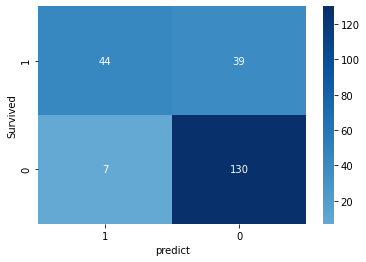

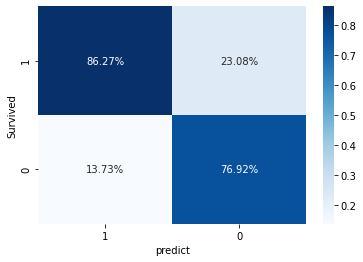

In [44]:
#Confusion Matrix for the Champion
df_matrix = datascored_df.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

In [45]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False).loc[:,('predict','p1')]        
        return self.predictions['p1'].astype('float64').values

In [46]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = datascored_df.loc[:,(selected_features)].sample(n=50, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [48]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

## 4.1 Main SHAP Graphics

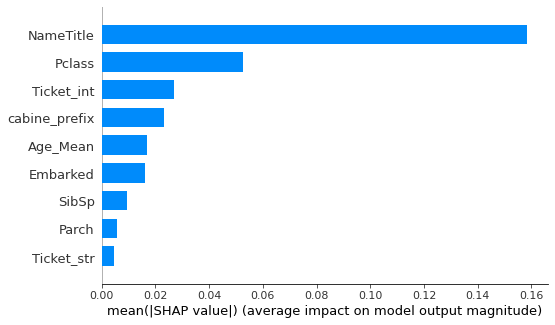

None

In [49]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

None

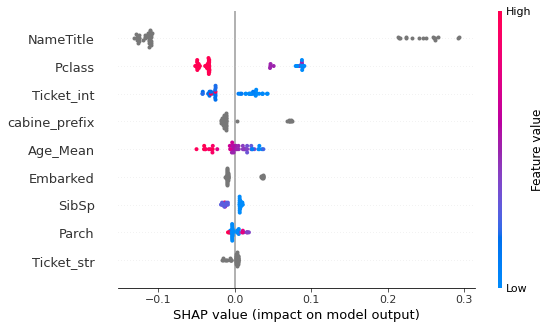

In [50]:
display(shap.summary_plot(h2o_shap_values, shap_sample, show=False))

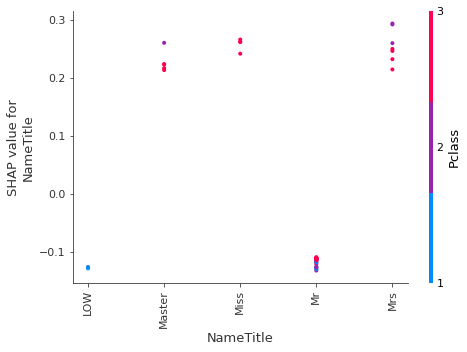

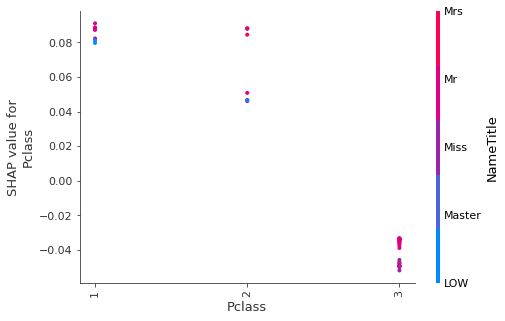

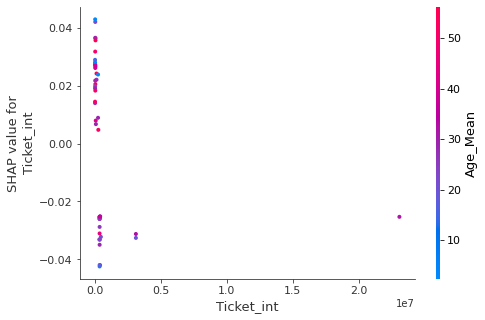

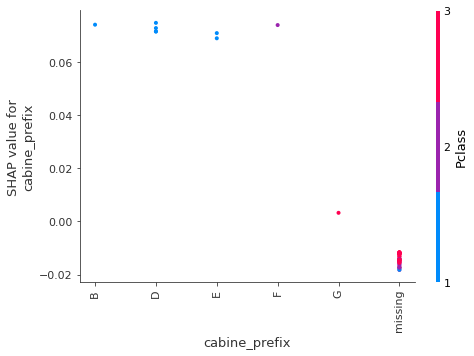

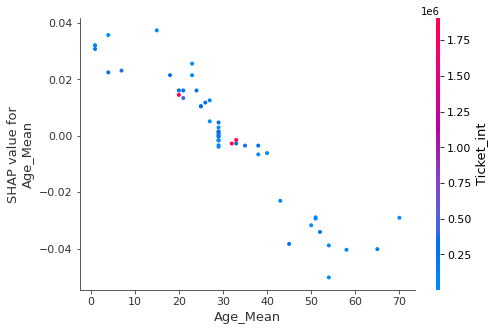

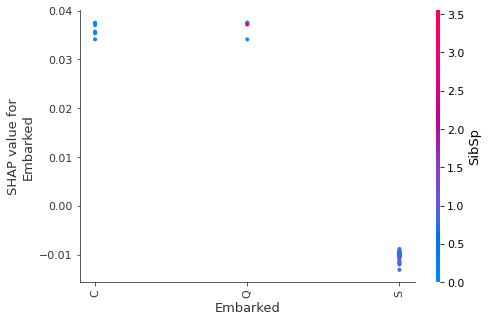

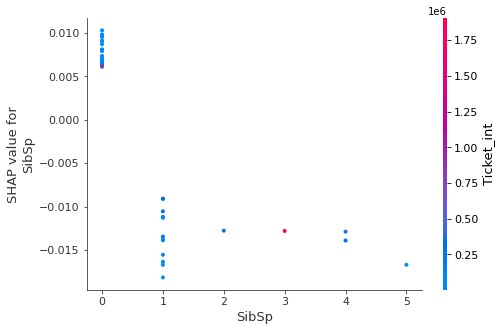

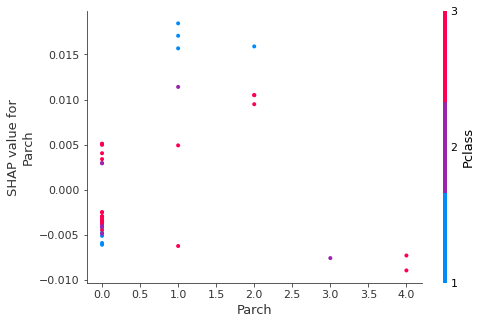

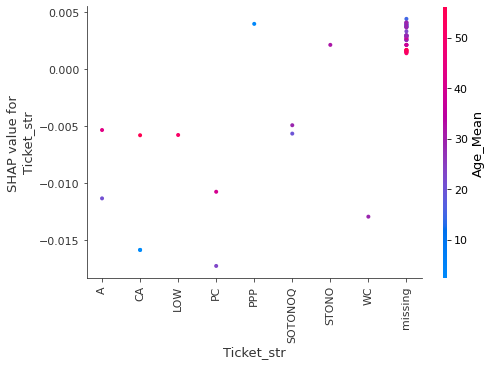

In [51]:
#sort the features indexes by their importance in the model
#(sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(h2o_shap_values),0))

#make SHAP plots of the three most important features
for i in range(len(selected_features)):
    fig=shap.dependence_plot(top_inds[i], h2o_shap_values, shap_sample, show=False)
#     display(fig)

## 4.2 Shap Waterfall Plot

In [52]:
df_shap_values = pd.DataFrame(h2o_shap_values)
df_shap_values['sum_shap'] = df_shap_values.sum(axis=1)

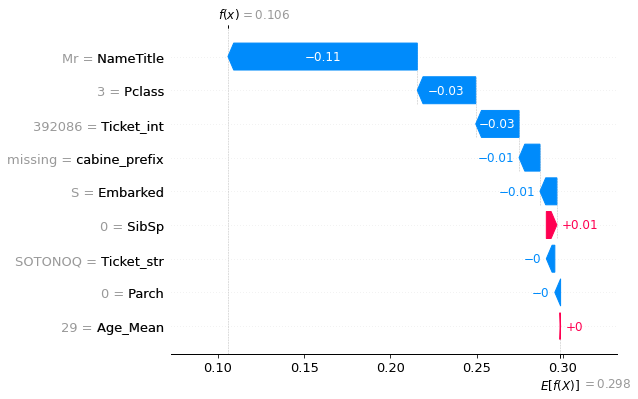

None

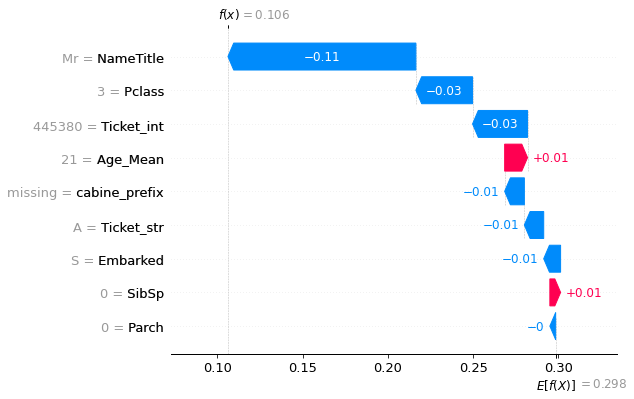

None

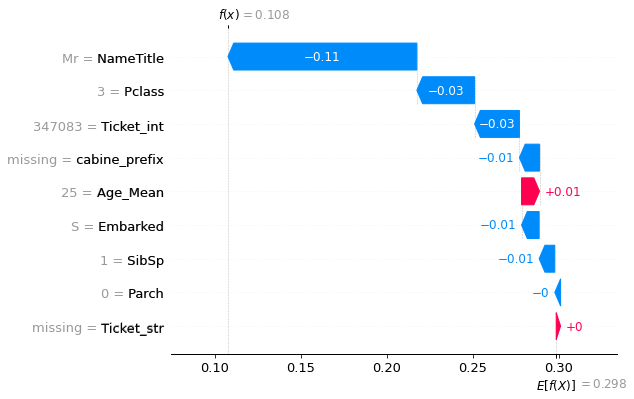

None

In [53]:
for i in df_shap_values.sort_values(by='sum_shap').iloc[0:3,:].index.values:
    fig = shap.plots._waterfall.waterfall_legacy(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:].to_numpy(), selected_features, show=True)
    display(fig)

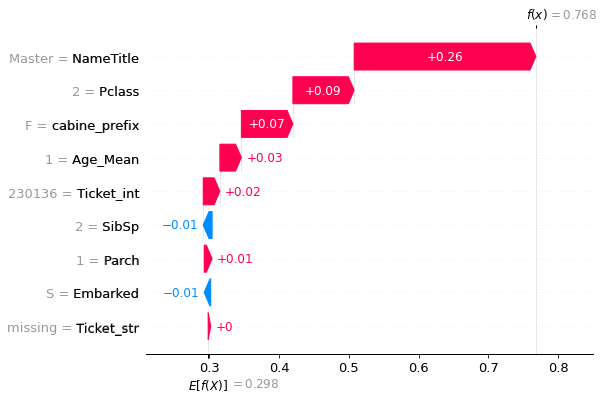

None

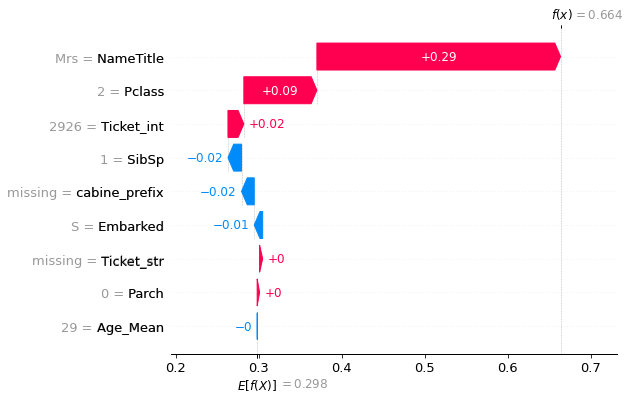

None

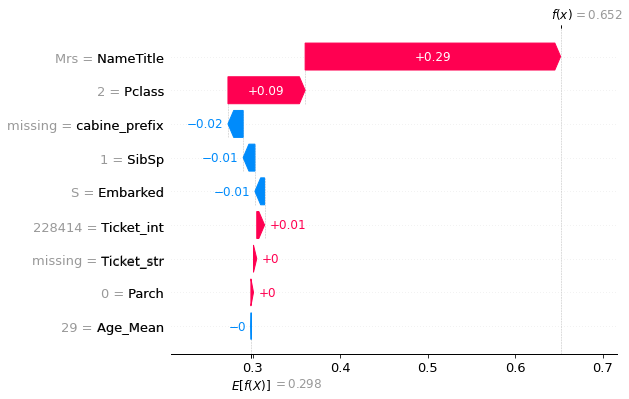

None

In [54]:
for i in df_shap_values.sort_values(by='sum_shap', ascending=False).iloc[0:3,:].index.values:
    fig = shap.plots._waterfall.waterfall_legacy(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:].to_numpy(), selected_features, show=True)
    display(fig)

# 5. Define Ratings with homogeneous group

In [55]:
def calculate_IV(dataframe, coluna_feature, coluna_target, cat_goods = None, buckets=20):
    '''
    Function to calculate the IV.
         Parameters
         dataframe: DataFrame with the input and target variables.
         column_feature (str): Name of the variable that contains the independent variable.
         column_target (str): Name of the variable that contains the dependent variable or target.
         cat_goods (str): Level of the target variable that should be considered "GOOD", if it is categorical.
         buckets (int): Number of partitions to be created in numeric variables.
    
    Returns
    stats (list):
    List with:
        [1] IV
        [0] dataframe pandas with statistics table
    '''
    
    # Initial definitions
    df = dataframe.loc[:,(coluna_feature, coluna_target)]
    tpVar = 'categorical'    
    
    #If the variable is numeric (float or int), it creates a category for discretization
    if df[coluna_feature].dtype=='float64' or df[coluna_feature].dtype=='int64' or df[coluna_feature].dtype=='int32' or df[coluna_feature].dtype=='float32':
        tpVar='numeric'
        coluna_feature_bucket = coluna_feature + "_bucket"
        #create buckets using qcut
        df[coluna_feature_bucket] = pd.qcut(df[coluna_feature], buckets, labels=False, duplicates='drop')
        analyse_df = df.groupby(coluna_feature_bucket).agg({coluna_target: ['count', 'sum'], coluna_feature: ['min', 'max']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #Categorical variables
    if tpVar == 'categorical':
        analyse_df = df.groupby(coluna_feature).agg({coluna_target: ['count', 'sum']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #IV Calculation
    analyse_df.loc[:, 'qty_bads'] = analyse_df.loc[:,'qty'] - analyse_df.loc[:,'qty_goods']
    analyse_df.loc[:, 'tot_goods'] = analyse_df.loc[:,'qty_goods'].sum()
    analyse_df.loc[:, 'tot_bads'] = analyse_df.loc[:,'qty_bads'].sum()
    analyse_df.loc[:, 'perc_goods'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'tot_goods']
    analyse_df.loc[:, 'perc_bads'] = analyse_df.loc[:,'qty_bads'] / analyse_df.loc[:,'tot_bads']
    analyse_df.loc[:, 'good_rate'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'qty']
    analyse_df.loc[:, 'odds'] = analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']
    analyse_df.loc[:, 'ln_odds'] = np.log2(analyse_df['odds'])
    analyse_df.loc[:, 'iv_cat'] = (analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']) * analyse_df.loc[:, 'ln_odds']
    
    if tpVar == 'numeric':
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature_bucket, coluna_feature+"_min", coluna_feature+"_max", 'qty', 'good_rate', 'odds', 'iv_cat')]
    else:
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature, 'qty', 'good_rate', 'odds', 'iv_cat')]
        
    df_iv = tabela_pdf.query('iv_cat != inf')['iv_cat'].sum()
    resultado = [df_iv, tabela_pdf]
    return resultado

def colunas_dataframe(dataframe):
    lista_colunas = []
    lista_colunas = [i for i in dataframe.columns if i in selected_features]
    return lista_colunas

def table_iv(dataframe):
    lista_colunas = colunas_dataframe(dataframe)
    dict_resultados = {}
    for col in lista_colunas:
        print("{0:.0%}".format((lista_colunas.index(col)+1) / (len(lista_colunas)+1)) + ":" + col)              
        dict_resultados[col] = calculate_IV(dataframe=dataframe, coluna_feature=col, coluna_target=VarTarget, buckets=10)
    return dict_resultados

In [56]:
#Calcular Taxa de Bons, IV, ODDS e WOE
IV_p1=calculate_IV(dataframe=datascored_df, coluna_feature='p1', coluna_target=VarTarget, buckets=20)
#IV_p1

divide by zero encountered in log2


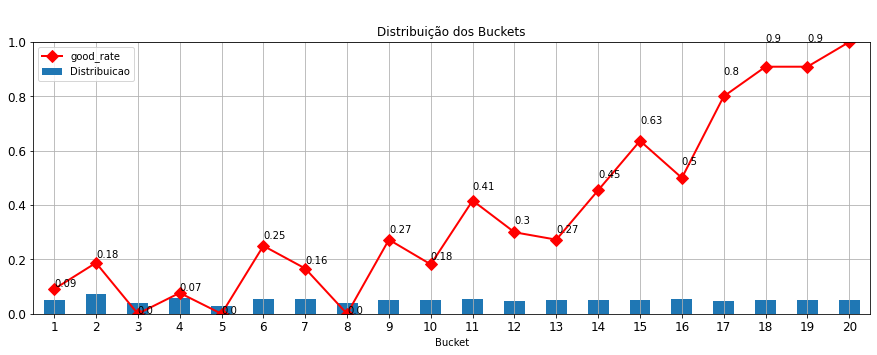

In [57]:
IV_GH_graf = IV_p1[1]
IV_GH_graf['Bucket'] = IV_GH_graf.index+1
IV_GH_graf['Bucket'] = IV_GH_graf['Bucket'].astype(int)
IV_GH_graf = IV_GH_graf.sort_values(by='Bucket')                                     
IV_GH_graf.set_index('Bucket', inplace=True)
#IV_GH_graf

IV_GH_graf['Distribuicao'] = IV_GH_graf.qty / IV_GH_graf.qty.sum()
df_plot_gh_t1 = IV_GH_graf.reset_index().loc[:, ('Bucket', 'Distribuicao')]                                                
df_plot_gh_t1['Bucket'] = df_plot_gh_t1.Bucket.astype(str)
df_plot_gh_t1 = df_plot_gh_t1.set_index('Bucket')

df_plot_gh_t2 = IV_GH_graf.reset_index().loc[:, ('Bucket', 'good_rate')]
df_plot_gh_t2['Bucket'] = df_plot_gh_t2.Bucket.astype(str)
df_plot_gh_t2 = df_plot_gh_t2.set_index('Bucket')

ax = df_plot_gh_t2.good_rate.plot(secondary_y=False, ylim=[0,1], kind="line", rot=0, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(df_plot_gh_t2)):
    ax.annotate(str(int(df_plot_gh_t2.reset_index().iloc[p,1]*100)/100), (int(df_plot_gh_t2.reset_index().iloc[p, 0])-1, df_plot_gh_t2.reset_index().iloc[p, 1] * 1.1))
df_plot_gh_t1.Distribuicao.plot(ylim=[0,1], kind='bar', rot=0, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title="Distribuição dos Buckets")
#display(ax)

## 5.1 Escolher as faixas que podem ser agrupadas

In [58]:
for i in range(len(IV_p1[1].p1_max)):
    #se for o primeiro iniciar com if ao inves de elif
    if i==0:
        print('if p1 <= '+str(IV_p1[1].p1_max.iloc[i])+':')
        print('    return '+ str(i+1))
    #se for o ultimo finalizar com else ao inves de elif
    elif i==(len(IV_p1[1].p1_max))-1:
        print('else:')
        print('    return '+ str(i+1))
    else:
        print('elif p1 <= '+str(IV_p1[1].p1_max.iloc[i])+':')
        print('    return '+ str(i+1))

if p1 <= 0.1120064931452788:
    return 1
elif p1 <= 0.1158597733185995:
    return 2
elif p1 <= 0.1183053451496254:
    return 3
elif p1 <= 0.1257972609129387:
    return 4
elif p1 <= 0.1489519370188294:
    return 5
elif p1 <= 0.1608103959253382:
    return 6
elif p1 <= 0.1746120216958007:
    return 7
elif p1 <= 0.1924186953090161:
    return 8
elif p1 <= 0.2180300633186048:
    return 9
elif p1 <= 0.2821085932168102:
    return 10
elif p1 <= 0.3446990409459845:
    return 11
elif p1 <= 0.3992163437784312:
    return 12
elif p1 <= 0.4370686907210606:
    return 13
elif p1 <= 0.468307786233222:
    return 14
elif p1 <= 0.5054596388629075:
    return 15
elif p1 <= 0.5441608671988534:
    return 16
elif p1 <= 0.588546585601757:
    return 17
elif p1 <= 0.6893817258354984:
    return 18
elif p1 <= 0.791061511103377:
    return 19
else:
    return 20


In [59]:
def ratings(p1): 
    if p1 <= 0.2508362656036639:
        return 1
    elif p1 <= 0.6540492277407066:
        return 2
    else:
        return 3

In [60]:
#Criar GHs
datascored_df['GH'] = datascored_df.apply(lambda x: ratings(x['p1']),axis=1).astype(str)

## 5.2 Calcular o IV do GH após a definição das faixas

In [61]:
#Aqui precisa ser somente OOT
IV_GH=calculate_IV(dataframe=datascored_df, coluna_feature='GH', coluna_target=VarTarget)
IV_GH[1];

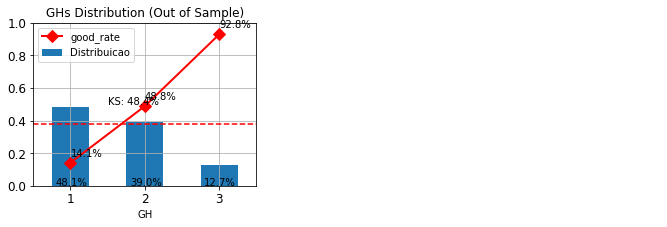

In [62]:
IV_GH_graf = IV_GH[1]
IV_GH_graf['GH'] = IV_GH_graf['GH'].astype(int)
IV_GH_graf = IV_GH_graf.sort_values(by='GH')
IV_GH_graf.set_index('GH', inplace=True)
#IV_GH_graf

IV_GH_graf['Distribuicao'] = IV_GH_graf.qty / IV_GH_graf.qty.sum()
df_plot_gh_t1 = IV_GH_graf.reset_index().loc[:, ('GH', 'Distribuicao')]
df_plot_gh_t1['GH'] = df_plot_gh_t1.GH.astype(str)
df_plot_gh_t1 = df_plot_gh_t1.set_index('GH')

df_plot_gh_t2 = IV_GH_graf.reset_index().loc[:, ('GH', 'good_rate')]
df_plot_gh_t2['GH'] = df_plot_gh_t2.GH.astype(str)
df_plot_gh_t2 = df_plot_gh_t2.set_index('GH')

target_mean = sum(IV_GH[1].qty * IV_GH[1].good_rate) / sum(IV_GH[1].qty)

#calculate o KS in test dataset
kstable = IV_GH_graf.sort_values(by="good_rate", ascending=False).copy()
kstable['events'] = (kstable['qty']*kstable['good_rate'])
kstable['nonevents'] = (kstable['qty']*(1-kstable['good_rate']))
kstable['event_rate'] = (kstable.events / kstable['events'].sum()).apply('{0:.2%}'.format)
kstable['nonevent_rate'] = (kstable.nonevents / kstable['nonevents'].sum()).apply('{0:.2%}'.format)
kstable['cum_eventrate'] = (kstable.events / kstable['events'].sum()).cumsum()
kstable['cum_noneventrate'] = (kstable.nonevents / kstable['nonevents'].sum()).cumsum()
kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
ks = kstable['KS'].max()

ax = df_plot_gh_t2.good_rate.plot(secondary_y=False, ylim=[0,1], kind="line", rot=0, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(df_plot_gh_t2)):
    #ax.annotate(str(int(df_plot_gh_t2.reset_index().iloc[p,1]*100)/100), (int(df_plot_gh_t2.reset_index().iloc[p, 0])-1, df_plot_gh_t2.reset_index().iloc[p, 1] * 1.1))
    ax.annotate(str('{0:.1%}'.format(int(df_plot_gh_t2.reset_index().iloc[p,1]*1000)/1000))\
                ,(df_plot_gh_t2.reset_index().index.values[p]+0.0\
                  ,df_plot_gh_t2.reset_index().iloc[p,1]+0.04))
    ax.annotate(str('{0:.1%}'.format(int(df_plot_gh_t1.reset_index().iloc[p,1]*1000)/1000))\
                ,(df_plot_gh_t1.reset_index().index.values[p]-0.2\
                  ,0))
ax.annotate(str('{0:.1%}'.format(int(target_mean*1000)/1000))\
            ,(7.5\
              ,target_mean))
ax.annotate(str('KS: {0:.1%}'.format(ks)),(len(df_plot_gh_t1)/2-1,0.5))
df_plot_gh_t1.Distribuicao.plot(ylim=[0,1], kind='bar', rot=0, figsize=(4,3), linewidth=2, fontsize=12, grid=True, legend=1, title="GHs Distribution (Out of Sample)")
ax.axhline(y=target_mean, color='r', linestyle='--')
# display(ax)

# 6. Predict Submision dataset using MOJO or H2O Model

In [63]:
test = pd.read_csv('./titanic/test.csv')

In [64]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [65]:
#criar o prefix para a variavel cabine (A, B, C, D, ou E)
test['cabine_prefix'] = test['Cabin'].str[0:1]
test = test.fillna(value={'cabine_prefix': 'missing'})

#Tiket
import re
for i in range(len(test)):
    t=test.loc[i:i,'Ticket'].values
    t2=re.sub("[^0-9]", "", str(t))
    t3=re.sub('[^A-Za-z]+', '', str(t))
    if t2 != "":
        test.loc[i:i,'Ticket_int']=int(t2)
    if t3 != "":
        if t3 == 'SC':
            t3 = 'SCAHBasle'
        if t3 == 'SOP':
            t3 = 'SOPP'
        if t3 == 'C':
            t3 = 'CA'
        if t3 == 'FC':
            t3 = 'FCC'
        if t3 == 'PP':
            t3 = 'PPP'
        if t3 == 'SCOW':
            t3 = 'Fa'
        if t3 in ('AS', 'CASOTON', 'Fa', 'SCA','SOPP','SOTONO','SP'):
            t3='LOW'
        test.loc[i:i,'Ticket_str']=str(t3)

test['Ticket_int'] = test['Ticket_int'].fillna(0)
test = test.fillna(value={'Ticket_str': 'missing'})

#Name: Criar uma categoria com o titulo do nome
for i in range(len(test)):
    t1 = str(test.loc[i:i,'Name'].values)
    t2 = t1[0:t1.find('.')].split()[-1]
    if t2 in ('Rev', 'Capt', 'Don', 'Jonkheer'):
        t2='LOW'
    if t2 in ('Lady', 'Mme'):
        t2='Miss'
    test.loc[i:i,'NameTitle']=str(t2)

#Create the "Missing" category for missing values in string vaviables
test = test.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

#Tratamento da idade
test['Age_Mean'] = test['Age'].fillna(test['Age'].mean())

In [66]:
#Importar MOJO

test_tmp = h2o.mojo_predict_pandas(test, path_model_mojo)    
predict_df = test.merge(test_tmp, left_index=True, right_index=True)
    
predict_df.rename(columns={'predict':'Survived', 'passengerid': 'PassengerId'}, inplace=True)
predict_df = predict_df.reset_index(drop=True)
predict_df = predict_df.loc[:, ('PassengerId', 'Survived')]
predict_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


## 8.1 Save final dataset with predictions for submissions in https://www.kaggle.com/competitions/titanic/submissions

In [67]:
predict_df.loc[:, ('PassengerId', 'Survived')].to_csv('./titanic/titanic_submission.csv', index=False)